## Praktikum 1
RNN untuk Analisis Sentimen

Setup:

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

Setup input pipeline

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I have to finish watching a movie once I start, regardless of how bad it is. This movie was agonizing to sit through. The "sparkling" bullets, the reporter with "ninja" like moves, the way the bad guys shoot hundreds and hundreds of bullets and only seem to hit innocent bystanders, the predictable outcome and all the bad acting was just horrible. Like the girl who finds the reporter in her friends apartment and goes from "what the heck are you doing in here (holding a bat)" to "hey, you\'re cute, wanna @#$%!???" in like 1.2 seconds.... Just bad.... Save yourself an hour and forty minutes and go play with your kids (or dog)!'
 b"When my wife and I decided to watch this movie we thought it couldn't fail. I love Billy Crystal, my wife loves Julia Roberts and everyone we talked to said they loved it.<br /><br />We were misled, in spades.<br /><br />On my part, I felt Billy Crystal's character was extremely one-dimensional and did very little for the film. Sure, he cracked a coup

Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example


array([[ 10,  26,   6, ...,   0,   0,   0],
       [ 51,  56, 318, ...,   0,   0,   0],
       [ 10, 249,   2, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I have to finish watching a movie once I start, regardless of how bad it is. This movie was agonizing to sit through. The "sparkling" bullets, the reporter with "ninja" like moves, the way the bad guys shoot hundreds and hundreds of bullets and only seem to hit innocent bystanders, the predictable outcome and all the bad acting was just horrible. Like the girl who finds the reporter in her friends apartment and goes from "what the heck are you doing in here (holding a bat)" to "hey, you\'re cute, wanna @#$%!???" in like 1.2 seconds.... Just bad.... Save yourself an hour and forty minutes and go play with your kids (or dog)!'
Round-trip:  i have to [UNK] watching a movie once i start [UNK] of how bad it is this movie was [UNK] to sit through the [UNK] [UNK] the [UNK] with [UNK] like [UNK] the way the bad guys [UNK] [UNK] and [UNK] of [UNK] and only seem to hit [UNK] [UNK] the predictable [UNK] and all the bad acting was just horrible like the girl who finds the [UNK] in her

Buat Model

![image.png](attachment:image.png)

diagram model dapat dilihat pada gambar diatas
 1. Model ini dapat dibuat sebagai tf.keras.Sequential.
 2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
 3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
    - Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
    - Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi  representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide
Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.008634]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 58ms/step
[-0.008634]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train Model

In [15]:
history = model.fit(train_dataset, epochs=10,
                validation_data=test_dataset,
                validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 96ms/step - loss: 0.6386 - accuracy: 0.5704 - val_loss: 0.4900 - val_accuracy: 0.7146
Epoch 2/10
391/391 [==============================] - 25s 63ms/step - loss: 0.4391 - accuracy: 0.7862 - val_loss: 0.4676 - val_accuracy: 0.7469
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3757 - accuracy: 0.8285 - val_loss: 0.3636 - val_accuracy: 0.8417
Epoch 4/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3394 - accuracy: 0.8530 - val_loss: 0.3409 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3216 - accuracy: 0.8634 - val_loss: 0.3321 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3130 - accuracy: 0.8670 - val_loss: 0.3276 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3070 - accuracy: 0.8670 - val_loss: 0.3347 - val_accuracy:

Train Model

In [16]:
history = model.fit(train_dataset, epochs=10,
                  validation_data=test_dataset,
                  validation_steps=30)

Epoch 1/10
391/391 [==============================] - 25s 63ms/step - loss: 0.2957 - accuracy: 0.8736 - val_loss: 0.3261 - val_accuracy: 0.8589
Epoch 2/10
391/391 [==============================] - 24s 61ms/step - loss: 0.2969 - accuracy: 0.8734 - val_loss: 0.3315 - val_accuracy: 0.8599
Epoch 3/10
391/391 [==============================] - 24s 61ms/step - loss: 0.2953 - accuracy: 0.8765 - val_loss: 0.3263 - val_accuracy: 0.8583
Epoch 4/10
391/391 [==============================] - 25s 62ms/step - loss: 0.2940 - accuracy: 0.8762 - val_loss: 0.3208 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.2902 - accuracy: 0.8772 - val_loss: 0.3221 - val_accuracy: 0.8604
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 0.2891 - accuracy: 0.8795 - val_loss: 0.3279 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.2872 - accuracy: 0.8784 - val_loss: 0.3222 - val_accuracy:

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 28ms/step - loss: 0.3187 - accuracy: 0.8584
Test Loss: 0.3186837434768677
Test Accuracy: 0.8584399819374084


(0.0, 0.3340484738349915)

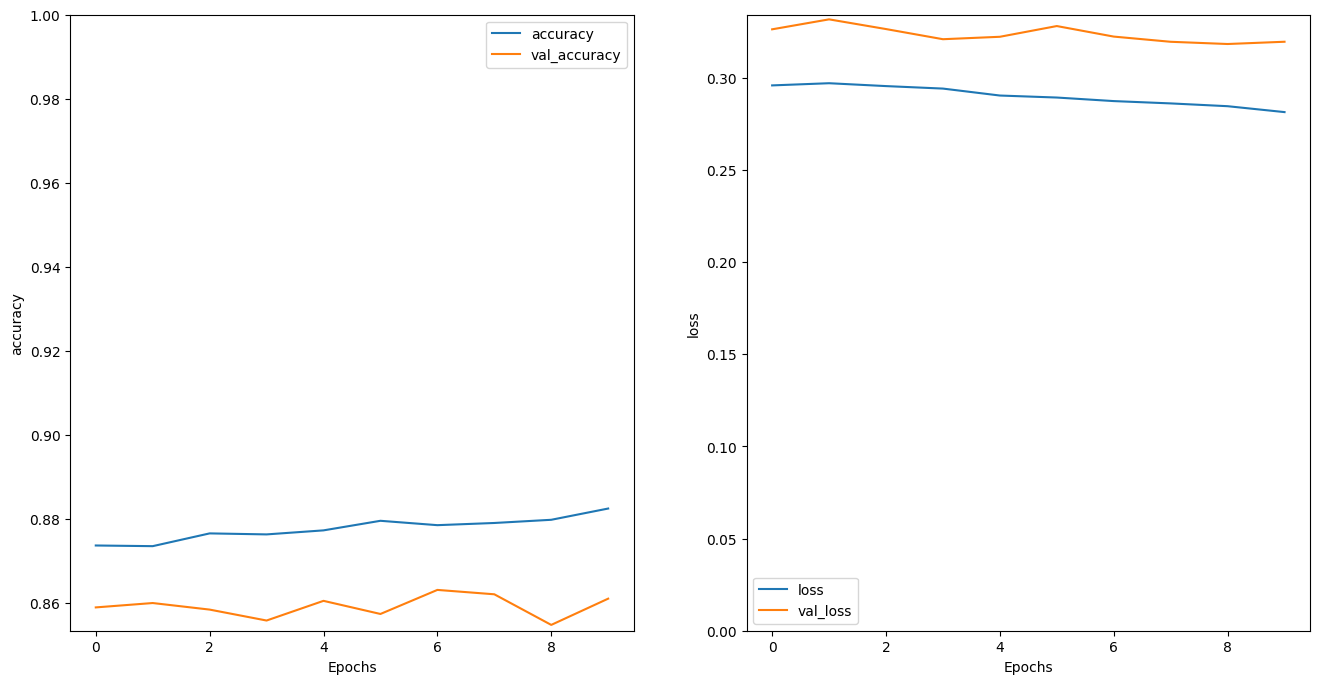

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


### Stack two or more LSTM layers

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :
- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut adalah alur informasi dengan return_sequences=True:

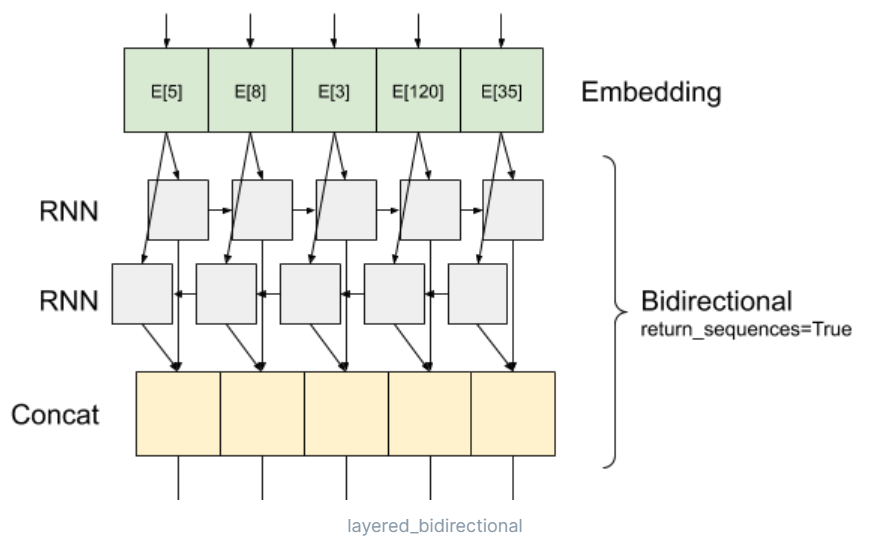

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
    validation_data=test_dataset,
    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 81s 155ms/step - loss: 0.6581 - accuracy: 0.5534 - val_loss: 0.4889 - val_accuracy: 0.7812
Epoch 2/10
391/391 [==============================] - 47s 120ms/step - loss: 0.4087 - accuracy: 0.8207 - val_loss: 0.3604 - val_accuracy: 0.8354
Epoch 3/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3419 - accuracy: 0.8525 - val_loss: 0.3382 - val_accuracy: 0.8391
Epoch 4/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3261 - accuracy: 0.8598 - val_loss: 0.3297 - val_accuracy: 0.8552
Epoch 5/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3134 - accuracy: 0.8666 - val_loss: 0.3211 - val_accuracy: 0.8604
Epoch 6/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3096 - accuracy: 0.8676 - val_loss: 0.3227 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3064 - accuracy: 0.8714 - val_loss: 0.3143 - val_ac

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 56ms/step - loss: 0.3147 - accuracy: 0.8593
Test Loss: 0.31469225883483887
Test Accuracy: 0.859279990196228


In [28]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
            'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-2.0365486]]


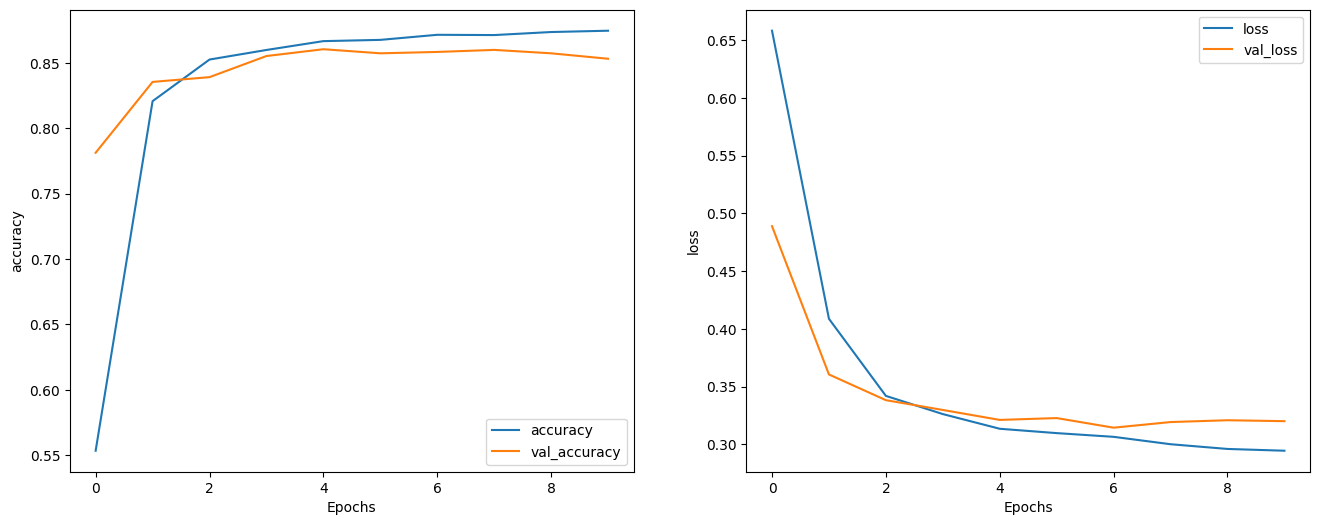

In [29]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')